In [1]:
import pandas as pd
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import cross_val_score, GridSearchCV, KFold
from sklearn.linear_model import Lasso, Ridge, ElasticNet
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

### I. Setup
Load the dataset- remove columns with missing values. Identify numeric and categorical features and target.

In [9]:
# Load the dataset
ames = pd.read_csv('ames.csv')

# Identify numeric and categorical features, excluding 'PID' and 'SalePrice'
ames['MSSubClass'] = ames['MSSubClass'].astype(str) #Nominal variable of 'string' integers
numeric_features = ames.select_dtypes(include=['int64', 'float64']).drop(columns=['PID', 'SalePrice', 'Unnamed: 0', 'OverallQual']).columns
categorical_features = ames.select_dtypes(include=['object']).columns
X = ames[numeric_features.tolist() + categorical_features.tolist()]

# Target variable
y = ames['SalePrice']

### II. Set up Pipelines:
For pre-processing and regression with 5-fold cross-validation. Scale numerical data, one-hot encode the rest. Instantiate Lasso, Ridge, and ElasticNet models.

In [10]:
# Pipeline for numeric and categorical features
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])
categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False)) #Retain all features for PLR
])
# Combined preprocessor for both numeric and categorical data
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])
# Define the model pipelines with preprocessor and regressor
pipelines = {
    'Lasso': Pipeline(steps=[('preprocessor', preprocessor), ('regressor', Lasso(max_iter=30000, tol = .001))]),
    'Ridge': Pipeline(steps=[('preprocessor', preprocessor), ('regressor', Ridge())]),
    'ElasticNet': Pipeline(steps=[('preprocessor', preprocessor), ('regressor', ElasticNet(max_iter=30000, tol = .001))])
}

### III. Run PLR's: 
Report the scores of all three methods of PLR on all variables with no fine-tuning of hyperparameters- basic idea of how these models perform.

In [23]:
# Perform cross-validation and store results in a dictionary
cv_results = {} 
for name, pipeline in pipelines.items():
    scores = cross_val_score(pipeline, X, y)
    cv_results[name] = round(scores.mean(), 4)
# Output the mean cross-validation scores
print(cv_results)

{'Lasso': 0.906, 'Ridge': 0.9094, 'ElasticNet': 0.862}


### IV. Tuning: Lasso
Find optimal alpha for lasso model. Start with a wide range of alphas and run through GridSearchCV. Gradually narrow window of alphas until you find alpha that yields best R^2.

In [12]:
#Helper Functions
def alpha_tune_plot(mygridsearch, model_string):
    """alpha_tune_plot: Input gridsearchcv object
                              model_string: used for title of plot
                        Output displaying best alpha and train-test results"""
    results = mygridsearch.cv_results_
    train_score = results['mean_train_score']
    test_score = results['mean_test_score']
    alphas = results['param_regressor__alpha'].data.astype(float)

    
    best_alpha = mygridsearch.best_params_['regressor__alpha']

    plt.figure(figsize=(10, 6))
    plt.plot(alphas, train_score, label = 'Train', marker='o')
    plt.plot(alphas, test_score, label = 'Test', marker = 'o')
    plt.title(f'Tuning Alpha: {model_string} Alpha vs. R$^2$ with 5-Fold Cross-Validation')
    plt.xlabel('Alpha')
    plt.ylabel('Average R2 Score')
    plt.grid(True)

    plt.axvline(x=best_alpha, color='r', linestyle='--', label = f'Best Alpha\n{round(best_alpha, 2)}')
    plt.legend()
    plt.show()
    print("Best parameters:", mygridsearch.best_params_)
    print("Best R-squared:", mygridsearch.best_score_)

def manual_lasso_grid_search(alphas):
    """Manual_grid_search: Manual version of GridSearchCV to illustrate the process.
        alphas: Iterable (range, list, np.array) of alphas to test
        
        Output: Prints rmse and R2 for each fold of cross-validation for each alpha, then prints
        the alpha that yields the highest cross-validated R2 and that R2."""

    #Instantiate Holder Variables and KFold
    best_alpha = None
    best_score = -np.inf
    kf = KFold(n_splits = 5, shuffle= False)

    #Iterate through alphas
    for alpha in alphas:
        print(f"{alpha = }")

        #Holder lists for rmse and R2s for each fold
        rmse_scores = []
        r2_scores = []

        #Iterate through each fold
        for fold, (train_index, test_index) in enumerate(kf.split(X)):
            X_train, X_test = X.iloc[train_index], X.iloc[test_index]
            y_train, y_test = y.iloc[train_index], y.iloc[test_index]

            #scales numerical data and onehotencodes the rest
            X_train_scaled = preprocessor.fit_transform(X_train)
            X_test_scaled = preprocessor.transform(X_test)

            #instantiate and fit lasso
            lasso = Lasso(alpha = alpha, max_iter = 30000, tol = .001)
            lasso.fit(X_train_scaled, y_train)

            #calculate scores
            y_pred = lasso.predict(X_test_scaled)
            rmse = np.sqrt(mean_squared_error(y_test, y_pred))
            r2 = r2_score(y_test, y_pred)
            rmse_scores.append(rmse)
            r2_scores.append(r2)

            print(f"Fold{fold+1}: RMSE = {round(rmse, 4)}, R2 = {round(r2, 4)}")

        #calculate score means for each fold and print
        mean_rmse = np.mean(rmse_scores)
        mean_r2 = np.mean(r2_scores)
        print(f"\nAverage RMSE: {round(mean_rmse, 4)}")
        print(f"Average R2: {round(mean_r2, 4)}")
        print('\n--------------------------')

        # Update the best parameters if the current score is better
        if mean_r2 > best_score:
            best_score = mean_r2
            best_alpha = alpha

    print(f"Best alpha: {best_alpha}")
    print(f"Best cross-validation score: {round(best_score, 4)}")

In [28]:
#This process encompassed in sklearn's GridSearchCV
manual_lasso_grid_search([1, 2, 3])

alpha = 1
Fold1: RMSE = 30720.5183, R2 = 0.8649
Fold2: RMSE = 23018.3165, R2 = 0.923
Fold3: RMSE = 20917.5583, R2 = 0.9131


KeyboardInterrupt: 

In [13]:
#Implement GridSearchCV on Lasso to obtain optimal alpha

# Define range of alpha values for Lasso
alpha = np.logspace(1, 5, 8)  # 10 to 100000

# Setup Grid Search for Lasso
lasso_grid = GridSearchCV(estimator=pipelines['Lasso'],
                          param_grid={'regressor__alpha': alpha},
                          return_train_score=True, 
                          verbose=1)
lasso_grid.fit(X, y)

# Extract the best alpha and best score Lasso
lasso_best_alpha = lasso_grid.best_params_['regressor__alpha']
lasso_best_score = lasso_grid.best_score_
print(f"Best alpha for Lasso: {lasso_best_alpha}")
print(f"Best cross-validation score: {round(lasso_best_score, 4)}")

Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV 1/5] END regressor__alpha=10.0;, score=(train=0.946, test=0.863) total time=   0.5s
[CV 2/5] END regressor__alpha=10.0;, score=(train=0.935, test=0.924) total time=   0.3s
[CV 3/5] END regressor__alpha=10.0;, score=(train=0.937, test=0.913) total time=   0.7s
[CV 4/5] END regressor__alpha=10.0;, score=(train=0.935, test=0.921) total time=   0.4s
[CV 5/5] END regressor__alpha=10.0;, score=(train=0.936, test=0.922) total time=   0.4s
[CV 1/5] END regressor__alpha=37.2759372031494;, score=(train=0.940, test=0.863) total time=   0.2s
[CV 2/5] END regressor__alpha=37.2759372031494;, score=(train=0.931, test=0.922) total time=   0.7s
[CV 3/5] END regressor__alpha=37.2759372031494;, score=(train=0.933, test=0.919) total time=   0.6s
[CV 4/5] END regressor__alpha=37.2759372031494;, score=(train=0.931, test=0.921) total time=   0.7s
[CV 5/5] END regressor__alpha=37.2759372031494;, score=(train=0.932, test=0.923) total time=   0.8s


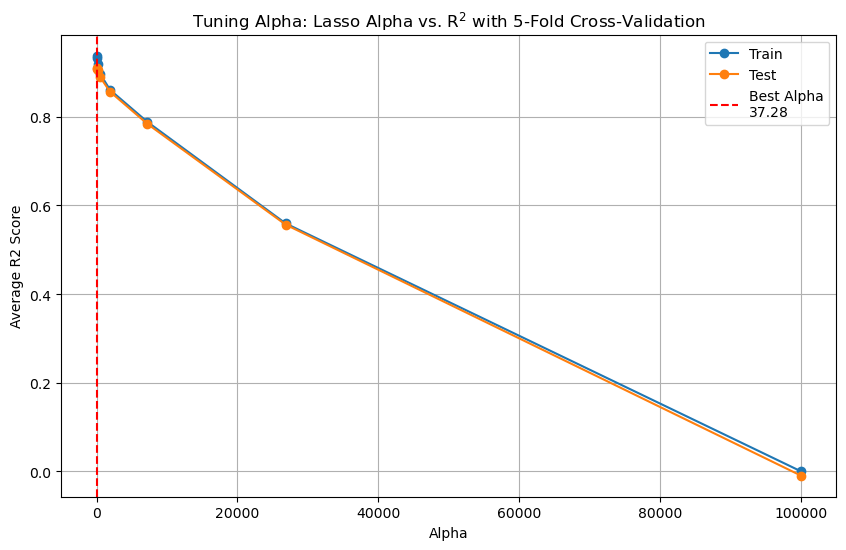

Best parameters: {'regressor__alpha': 37.2759372031494}
Best R-squared: 0.9097671246060217


In [14]:
alpha_tune_plot(lasso_grid, 'Lasso')

In [15]:
# Repeat and narrow scope
alpha = np.linspace(11, 141, 10)  #11 to 141 in 10 equal intervals

lasso_grid_1 = GridSearchCV(estimator=pipelines['Lasso'],
                          param_grid={'regressor__alpha': alpha}, #print per fold possible
                          return_train_score=True,
                          verbose=1) #Prints out progress
lasso_grid_1.fit(X, y)

lasso_best_alpha = lasso_grid_1.best_params_['regressor__alpha']
lasso_best_score = lasso_grid_1.best_score_
print(f"Best alpha for Lasso: {lasso_best_alpha}")
print(f"Best cross-validation score: {round(lasso_best_score, 4)}")

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV 1/5] END regressor__alpha=11.0;, score=(train=0.945, test=0.863) total time=   0.4s
[CV 2/5] END regressor__alpha=11.0;, score=(train=0.935, test=0.924) total time=   0.2s
[CV 3/5] END regressor__alpha=11.0;, score=(train=0.937, test=0.914) total time=   0.4s
[CV 4/5] END regressor__alpha=11.0;, score=(train=0.935, test=0.921) total time=   0.7s
[CV 5/5] END regressor__alpha=11.0;, score=(train=0.936, test=0.922) total time=   0.3s
[CV 1/5] END regressor__alpha=25.444444444444443;, score=(train=0.942, test=0.864) total time=   0.2s
[CV 2/5] END regressor__alpha=25.444444444444443;, score=(train=0.933, test=0.923) total time=   0.2s
[CV 3/5] END regressor__alpha=25.444444444444443;, score=(train=0.934, test=0.917) total time=   0.9s
[CV 4/5] END regressor__alpha=25.444444444444443;, score=(train=0.932, test=0.922) total time=   0.2s
[CV 5/5] END regressor__alpha=25.444444444444443;, score=(train=0.934, test=0.923) total ti

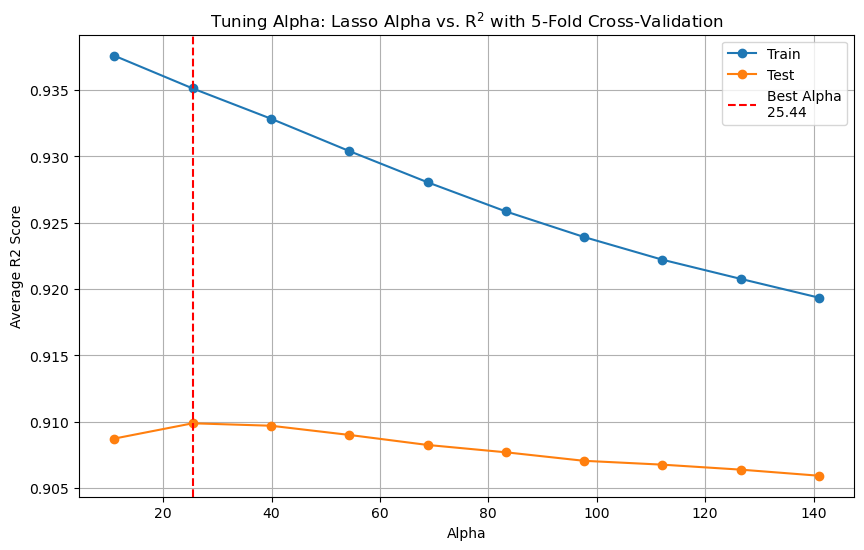

Best parameters: {'regressor__alpha': 25.444444444444443}
Best R-squared: 0.9098812439526289


In [16]:
alpha_tune_plot(lasso_grid_1, 'Lasso')

In [24]:
# Repeat and narrow scope
alpha = range(20, 40)

lasso_grid_2 = GridSearchCV(estimator=pipelines['Lasso'],
                          param_grid={'regressor__alpha': alpha}, #print per fold possible
                          return_train_score=True,
                          verbose=1) #Prints out progress
lasso_grid_2.fit(X, y)

lasso_best_alpha = lasso_grid_2.best_params_['regressor__alpha']
lasso_best_score = lasso_grid_2.best_score_
print(f"Best alpha for Lasso: {lasso_best_alpha}")
print(f"Best cross-validation score: {round(lasso_best_score, 4)}")

Fitting 5 folds for each of 20 candidates, totalling 100 fits
[CV 1/5] END regressor__alpha=20;, score=(train=0.943, test=0.863) total time=   0.2s
[CV 2/5] END regressor__alpha=20;, score=(train=0.934, test=0.924) total time=   0.2s
[CV 3/5] END regressor__alpha=20;, score=(train=0.935, test=0.916) total time=   0.2s
[CV 4/5] END regressor__alpha=20;, score=(train=0.933, test=0.922) total time=   0.2s
[CV 5/5] END regressor__alpha=20;, score=(train=0.934, test=0.923) total time=   1.9s
[CV 1/5] END regressor__alpha=21;, score=(train=0.943, test=0.863) total time=   0.2s
[CV 2/5] END regressor__alpha=21;, score=(train=0.933, test=0.924) total time=   0.2s
[CV 3/5] END regressor__alpha=21;, score=(train=0.935, test=0.917) total time=   0.2s
[CV 4/5] END regressor__alpha=21;, score=(train=0.933, test=0.922) total time=   0.2s
[CV 5/5] END regressor__alpha=21;, score=(train=0.934, test=0.923) total time=   1.2s
[CV 1/5] END regressor__alpha=22;, score=(train=0.943, test=0.864) total time=

[CV 2/5] END regressor__alpha=39;, score=(train=0.930, test=0.922) total time=   0.7s
[CV 3/5] END regressor__alpha=39;, score=(train=0.932, test=0.920) total time=   0.6s
[CV 4/5] END regressor__alpha=39;, score=(train=0.930, test=0.921) total time=   0.7s
[CV 5/5] END regressor__alpha=39;, score=(train=0.932, test=0.923) total time=   0.6s
Best alpha for Lasso: 29
Best cross-validation score: 0.91


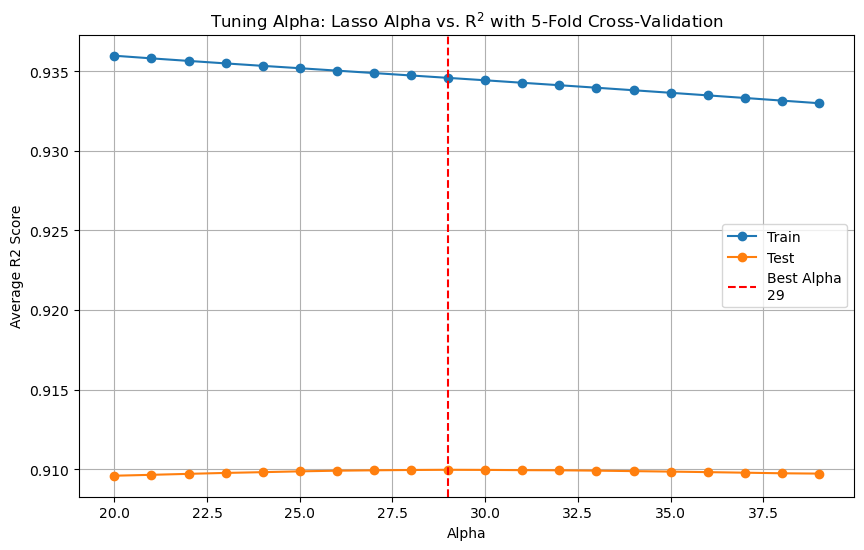

Best parameters: {'regressor__alpha': 29}
Best R-squared: 0.9099595110287219


In [18]:
alpha_tune_plot(lasso_grid_2, 'Lasso')

### V. Tuning: Lasso Results
Tuning the hyperparameter alpha to 29 improves the Lasso's R^2 from .906 to .9100, a difference of .004. Tune and compare Ridge.

### VI. Tuning: Ridge

In [19]:
#Implement GridSearchCV on Ridge to obtain optimal alpha

# Define range of alpha values for Lasso
alpha = np.logspace(1, 5, 8)  # 10 to 100000

# Setup Grid Search for Ridge
ridge_grid = GridSearchCV(estimator=pipelines['Ridge'],
                          param_grid={'regressor__alpha': alpha},
                          return_train_score=True, 
                          verbose=1) #Prints out progress
ridge_grid.fit(X, y)

ridge_best_alpha = ridge_grid.best_params_['regressor__alpha']
ridge_best_score = ridge_grid.best_score_
print(f"Best alpha for Lasso: {ridge_best_alpha}")
print(f"Best cross-validation score: {round(ridge_best_score, 4)}")

Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV 1/5] END regressor__alpha=10.0;, score=(train=0.941, test=0.860) total time=   0.1s
[CV 2/5] END regressor__alpha=10.0;, score=(train=0.927, test=0.919) total time=   0.1s
[CV 3/5] END regressor__alpha=10.0;, score=(train=0.927, test=0.925) total time=   0.1s
[CV 4/5] END regressor__alpha=10.0;, score=(train=0.928, test=0.918) total time=   0.1s
[CV 5/5] END regressor__alpha=10.0;, score=(train=0.928, test=0.923) total time=   0.1s
[CV 1/5] END regressor__alpha=37.2759372031494;, score=(train=0.934, test=0.860) total time=   0.1s
[CV 2/5] END regressor__alpha=37.2759372031494;, score=(train=0.919, test=0.912) total time=   0.1s
[CV 3/5] END regressor__alpha=37.2759372031494;, score=(train=0.918, test=0.924) total time=   0.1s
[CV 4/5] END regressor__alpha=37.2759372031494;, score=(train=0.920, test=0.914) total time=   0.1s
[CV 5/5] END regressor__alpha=37.2759372031494;, score=(train=0.919, test=0.920) total time=   0.1s


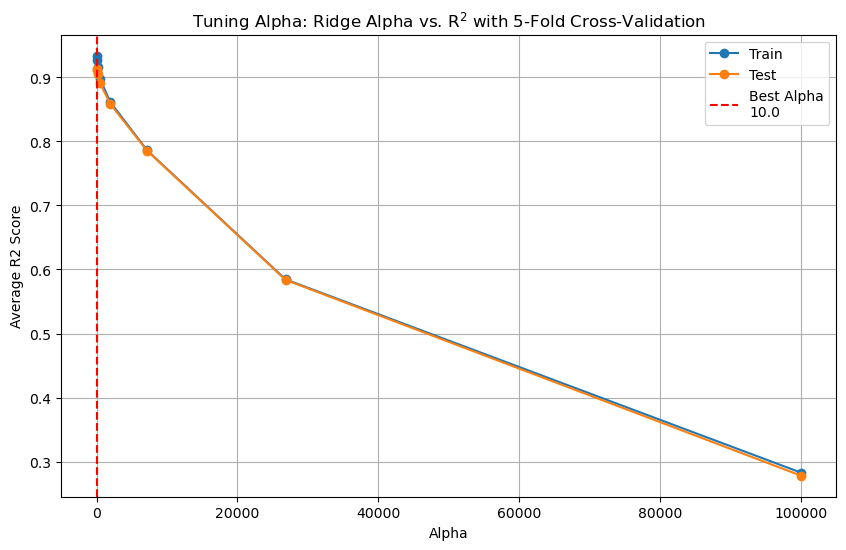

Best parameters: {'regressor__alpha': 10.0}
Best R-squared: 0.9134800298203508


In [36]:
alpha_tune_plot(ridge_grid, 'Ridge')

In [20]:
# Repeat and narrow scope

# Define range of alpha values for Ridge
alpha = range(1, 36)  # 1 to 10

ridge_grid_2 = GridSearchCV(estimator=pipelines['Ridge'],
                          param_grid={'regressor__alpha': alpha}, #print per fold possible
                          return_train_score=True, 
                          verbose=1) #Prints out progress
ridge_grid_2.fit(X, y)

ridge_best_alpha = ridge_grid_2.best_params_['regressor__alpha']
ridge_best_score = ridge_grid_2.best_score_
print(f"Best alpha for Lasso: {ridge_best_alpha}")
print(f"Best cross-validation score: {round(ridge_best_score, 4)}")

Fitting 5 folds for each of 35 candidates, totalling 175 fits
[CV 1/5] END regressor__alpha=1;, score=(train=0.946, test=0.863) total time=   0.1s
[CV 2/5] END regressor__alpha=1;, score=(train=0.935, test=0.924) total time=   0.1s
[CV 3/5] END regressor__alpha=1;, score=(train=0.937, test=0.918) total time=   0.1s
[CV 4/5] END regressor__alpha=1;, score=(train=0.935, test=0.921) total time=   0.1s
[CV 5/5] END regressor__alpha=1;, score=(train=0.936, test=0.921) total time=   0.1s
[CV 1/5] END regressor__alpha=2;, score=(train=0.945, test=0.862) total time=   0.1s
[CV 2/5] END regressor__alpha=2;, score=(train=0.934, test=0.923) total time=   0.1s
[CV 3/5] END regressor__alpha=2;, score=(train=0.935, test=0.922) total time=   0.1s
[CV 4/5] END regressor__alpha=2;, score=(train=0.934, test=0.920) total time=   0.1s
[CV 5/5] END regressor__alpha=2;, score=(train=0.935, test=0.922) total time=   0.1s
[CV 1/5] END regressor__alpha=3;, score=(train=0.944, test=0.861) total time=   0.1s
[CV

[CV 2/5] END regressor__alpha=20;, score=(train=0.923, test=0.916) total time=   0.1s
[CV 3/5] END regressor__alpha=20;, score=(train=0.923, test=0.925) total time=   0.1s
[CV 4/5] END regressor__alpha=20;, score=(train=0.924, test=0.916) total time=   0.1s
[CV 5/5] END regressor__alpha=20;, score=(train=0.924, test=0.922) total time=   0.1s
[CV 1/5] END regressor__alpha=21;, score=(train=0.938, test=0.860) total time=   0.1s
[CV 2/5] END regressor__alpha=21;, score=(train=0.923, test=0.915) total time=   0.1s
[CV 3/5] END regressor__alpha=21;, score=(train=0.923, test=0.925) total time=   0.1s
[CV 4/5] END regressor__alpha=21;, score=(train=0.924, test=0.916) total time=   0.1s
[CV 5/5] END regressor__alpha=21;, score=(train=0.924, test=0.922) total time=   0.1s
[CV 1/5] END regressor__alpha=22;, score=(train=0.938, test=0.860) total time=   0.1s
[CV 2/5] END regressor__alpha=22;, score=(train=0.922, test=0.915) total time=   0.1s
[CV 3/5] END regressor__alpha=22;, score=(train=0.922,

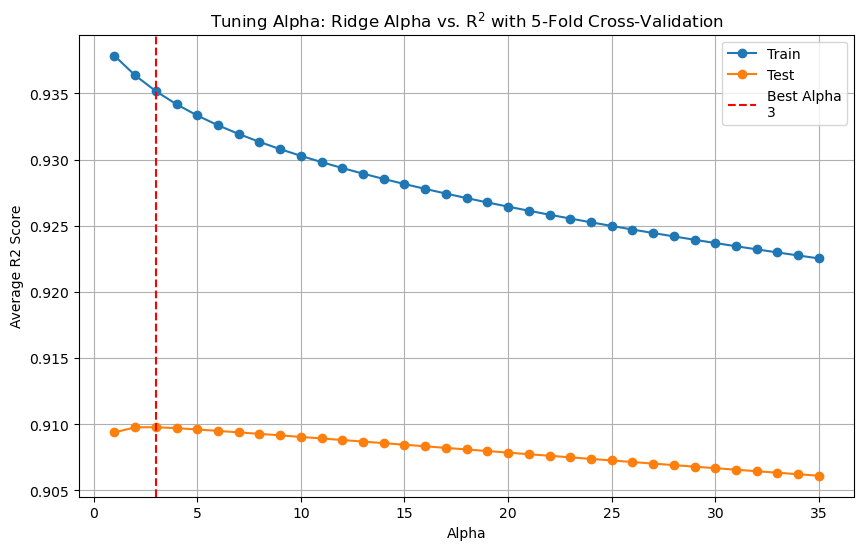

Best parameters: {'regressor__alpha': 3}
Best R-squared: 0.909771761237644


In [21]:
alpha_tune_plot(ridge_grid_2, 'Ridge')

In [51]:
# Repeat and narrow scope

# Define range of alpha values for Ridge
alpha = [.5, 1, 1.5, 2, 2.5, 3, 3.5, 4, 4.5, 5]

ridge_grid_3 = GridSearchCV(estimator=pipelines['Ridge'],
                          param_grid={'regressor__alpha': alpha}, #print per fold possible
                          return_train_score=True, 
                          verbose=1) #Prints out progress
ridge_grid_3.fit(X, y)

ridge_best_alpha = ridge_grid_3.best_params_['regressor__alpha']
ridge_best_score = ridge_grid_3.best_score_
print(f"Best alpha for Lasso: {ridge_best_alpha}")
print(f"Best cross-validation score: {round(ridge_best_score, 4)}")

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV 1/5] END regressor__alpha=0.5;, score=(train=0.947, test=0.864) total time=   0.1s
[CV 2/5] END regressor__alpha=0.5;, score=(train=0.936, test=0.923) total time=   0.1s
[CV 3/5] END regressor__alpha=0.5;, score=(train=0.938, test=0.915) total time=   0.1s
[CV 4/5] END regressor__alpha=0.5;, score=(train=0.936, test=0.920) total time=   0.1s
[CV 5/5] END regressor__alpha=0.5;, score=(train=0.937, test=0.921) total time=   0.1s
[CV 1/5] END regressor__alpha=1;, score=(train=0.946, test=0.863) total time=   0.1s
[CV 2/5] END regressor__alpha=1;, score=(train=0.935, test=0.924) total time=   0.1s
[CV 3/5] END regressor__alpha=1;, score=(train=0.937, test=0.918) total time=   0.1s
[CV 4/5] END regressor__alpha=1;, score=(train=0.935, test=0.921) total time=   0.1s
[CV 5/5] END regressor__alpha=1;, score=(train=0.936, test=0.921) total time=   0.1s
[CV 1/5] END regressor__alpha=1.5;, score=(train=0.946, test=0.862) total time=

### VII. Tuning: Ridge Results
Tuning the hyperparameter alpha to 2.5 improves the Ridge's R^2 from 'Ridge': 0.9094 to .9098, a difference of .0004. The tuned Ridge only slightly outperforms the Lasso. A next step here would be to see if ElasticNet, the combination of Lasso and Ridge, outperforms either model on its own.

### VIII. Tuning: ElasticNet
Need to tune two hyperparameters here, the l1_ratio (weight of Ridge vs. Lasso) and alpha.

In [27]:
def elasticnet_tune_plot(mygridsearch):
    """elasticnet_tune_plot: Input gridsearchcv object
                             Output displaying best alpha, l1_ratio and train-test results"""
    results = mygridsearch.cv_results_
    train_score = results['mean_train_score']
    test_score = results['mean_test_score']
    alphas = results['param_regressor__alpha'].data.astype(float)
    l1_ratios = results['param_regressor__l1_ratio'].data.astype(float)

    best_alpha = mygridsearch.best_params_['regressor__alpha']
    best_l1_ratio = mygridsearch.best_params_['regressor__l1_ratio']

    # Unique values of l1_ratio to create subplots
    unique_l1_ratios = np.unique(l1_ratios)

    plt.figure(figsize=(15, 10))

    for i, l1_ratio in enumerate(unique_l1_ratios):
        mask = l1_ratios == l1_ratio
        plt.subplot(len(unique_l1_ratios), 1, i + 1)
        plt.plot(alphas[mask], train_score[mask], label='Train', marker='o')
        plt.plot(alphas[mask], test_score[mask], label='Test', marker='o')
        plt.title(f'ElasticNet Alpha vs. R$^2$ with 5-Fold Cross-Validation (l1_ratio={l1_ratio})')
        plt.xlabel('Alpha')
        plt.ylabel('Average R2 Score')
        plt.grid(True)

        if l1_ratio == best_l1_ratio:
            plt.axvline(x=best_alpha, color='r', linestyle='--', label=f'Best Alpha\n{round(best_alpha, 2)}')
        
        plt.legend()

    plt.tight_layout()
    plt.show()
    
    print("Best parameters:", mygridsearch.best_params_)
    print("Best R-squared:", mygridsearch.best_score_)

In [25]:
#Implement GridSearchCV on ElasticNet to obtain optimal alpha

# Define range of alpha values and L1 Ratio
alpha_range = [.1, 1, 10, 100]
l1_ratio_range = [.25, .5, .75]

#Define parameter grid
param_grid = {
    'regressor__alpha': alpha_range,
    'regressor__l1_ratio': l1_ratio_range
}

# Setup Grid Search for ElasticNet
elastic_net_grid = GridSearchCV(estimator=pipelines['ElasticNet'],
                          param_grid= param_grid,
                          return_train_score=True, 
                          verbose=1) #Prints out progress
elastic_net_grid.fit(X, y)

# Extract the best alpha and best score ENet
elastic_net_best_alpha = elastic_net_grid.best_params_['regressor__alpha']
elastic_net_best_score = elastic_net_grid.best_score_
elastic_net_best_l1_ratio = elastic_net_grid.best_params_['regressor__l1_ratio']
print(f"Best alpha for ElasticNet: {elastic_net_best_alpha}")
print(f"Best l1_ratio cross-validation score: {round(elastic_net_best_l1_ratio, 4)}")
print(f"Best cross-validation score: {round(elastic_net_best_score, 4)}")

Fitting 5 folds for each of 12 candidates, totalling 60 fits
[CV 1/5] END regressor__alpha=0.1, regressor__l1_ratio=0.25;, score=(train=0.919, test=0.858) total time=   0.3s
[CV 2/5] END regressor__alpha=0.1, regressor__l1_ratio=0.25;, score=(train=0.903, test=0.896) total time=   0.3s
[CV 3/5] END regressor__alpha=0.1, regressor__l1_ratio=0.25;, score=(train=0.903, test=0.915) total time=   0.3s
[CV 4/5] END regressor__alpha=0.1, regressor__l1_ratio=0.25;, score=(train=0.905, test=0.903) total time=   0.7s
[CV 5/5] END regressor__alpha=0.1, regressor__l1_ratio=0.25;, score=(train=0.904, test=0.908) total time=   0.3s
[CV 1/5] END regressor__alpha=0.1, regressor__l1_ratio=0.5;, score=(train=0.924, test=0.859) total time=   0.4s
[CV 2/5] END regressor__alpha=0.1, regressor__l1_ratio=0.5;, score=(train=0.908, test=0.902) total time=   0.4s
[CV 3/5] END regressor__alpha=0.1, regressor__l1_ratio=0.5;, score=(train=0.908, test=0.919) total time=   0.4s
[CV 4/5] END regressor__alpha=0.1, reg

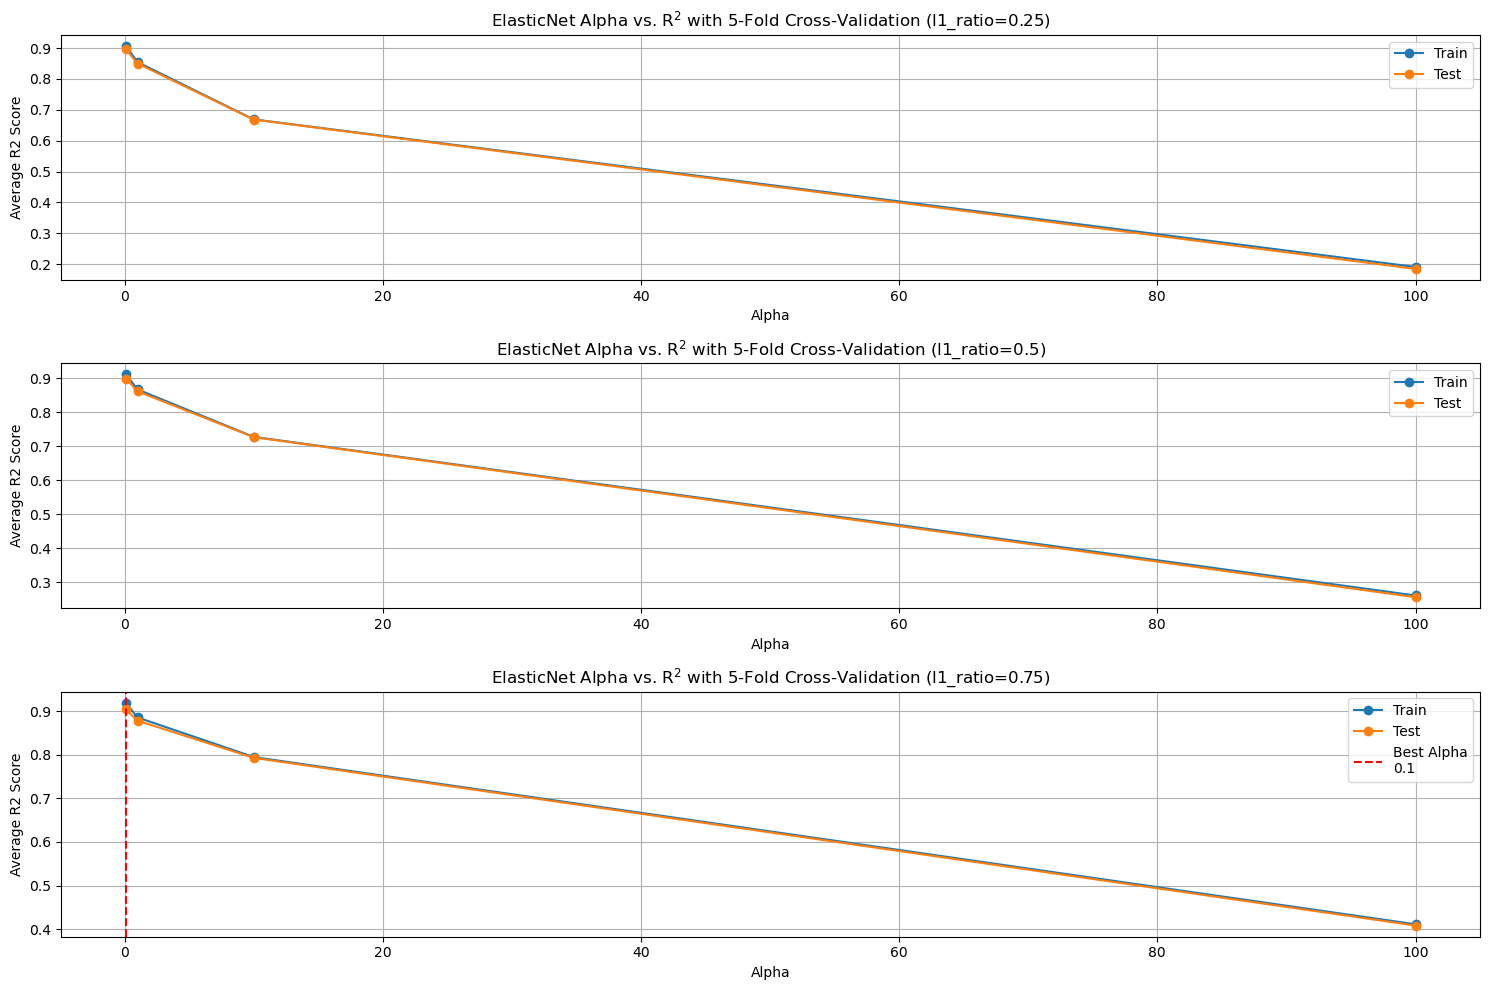

Best parameters: {'regressor__alpha': 0.1, 'regressor__l1_ratio': 0.75}
Best R-squared: 0.9043139104052329


In [28]:
elasticnet_tune_plot(elastic_net_grid)

In [29]:
# Repeat and narrow scope

# Define range of alpha values and L1 Ratio
alpha_range = [.1, .2, .3, .4, .5, .6, .7, .8, .9, 1]
l1_ratio_range = [.6, .65, .7, .75, .8, .85, .9, .95, .99]

#Define parameter grid
param_grid = {
    'regressor__alpha': alpha_range,
    'regressor__l1_ratio': l1_ratio_range
}

elastic_net_grid_1 = GridSearchCV(estimator=pipelines['ElasticNet'],
                          param_grid= param_grid,
                          return_train_score=True, 
                          verbose=1) #Prints out progress
elastic_net_grid_1.fit(X, y)

elastic_net_best_alpha = elastic_net_grid_1.best_params_['regressor__alpha']
elastic_net_best_score = elastic_net_grid_1.best_score_
elastic_net_best_l1_ratio = elastic_net_grid_1.best_params_['regressor__l1_ratio']
print(f"Best alpha for ElasticNet: {elastic_net_best_alpha}")
print(f"Best l1_ratio cross-validation score: {round(elastic_net_best_l1_ratio, 4)}")
print(f"Best cross-validation score: {round(elastic_net_best_score, 4)}")

Fitting 5 folds for each of 90 candidates, totalling 450 fits
[CV 1/5] END regressor__alpha=0.1, regressor__l1_ratio=0.6;, score=(train=0.927, test=0.859) total time=   0.5s
[CV 2/5] END regressor__alpha=0.1, regressor__l1_ratio=0.6;, score=(train=0.911, test=0.905) total time=   0.5s
[CV 3/5] END regressor__alpha=0.1, regressor__l1_ratio=0.6;, score=(train=0.911, test=0.920) total time=   0.9s
[CV 4/5] END regressor__alpha=0.1, regressor__l1_ratio=0.6;, score=(train=0.913, test=0.909) total time=   0.5s
[CV 5/5] END regressor__alpha=0.1, regressor__l1_ratio=0.6;, score=(train=0.912, test=0.914) total time=   0.5s
[CV 1/5] END regressor__alpha=0.1, regressor__l1_ratio=0.65;, score=(train=0.928, test=0.860) total time=   0.4s
[CV 2/5] END regressor__alpha=0.1, regressor__l1_ratio=0.65;, score=(train=0.912, test=0.906) total time=   0.5s
[CV 3/5] END regressor__alpha=0.1, regressor__l1_ratio=0.65;, score=(train=0.912, test=0.921) total time=   0.5s
[CV 4/5] END regressor__alpha=0.1, regr

[CV 4/5] END regressor__alpha=0.2, regressor__l1_ratio=0.85;, score=(train=0.916, test=0.911) total time=   0.4s
[CV 5/5] END regressor__alpha=0.2, regressor__l1_ratio=0.85;, score=(train=0.915, test=0.917) total time=   0.4s
[CV 1/5] END regressor__alpha=0.2, regressor__l1_ratio=0.9;, score=(train=0.933, test=0.860) total time=   0.5s
[CV 2/5] END regressor__alpha=0.2, regressor__l1_ratio=0.9;, score=(train=0.918, test=0.911) total time=   0.5s
[CV 3/5] END regressor__alpha=0.2, regressor__l1_ratio=0.9;, score=(train=0.917, test=0.923) total time=   0.5s
[CV 4/5] END regressor__alpha=0.2, regressor__l1_ratio=0.9;, score=(train=0.919, test=0.913) total time=   0.5s
[CV 5/5] END regressor__alpha=0.2, regressor__l1_ratio=0.9;, score=(train=0.918, test=0.919) total time=   0.5s
[CV 1/5] END regressor__alpha=0.2, regressor__l1_ratio=0.95;, score=(train=0.938, test=0.860) total time=   1.0s
[CV 2/5] END regressor__alpha=0.2, regressor__l1_ratio=0.95;, score=(train=0.923, test=0.916) total t

[CV 2/5] END regressor__alpha=0.4, regressor__l1_ratio=0.7;, score=(train=0.896, test=0.887) total time=   0.2s
[CV 3/5] END regressor__alpha=0.4, regressor__l1_ratio=0.7;, score=(train=0.895, test=0.910) total time=   0.2s
[CV 4/5] END regressor__alpha=0.4, regressor__l1_ratio=0.7;, score=(train=0.898, test=0.897) total time=   0.2s
[CV 5/5] END regressor__alpha=0.4, regressor__l1_ratio=0.7;, score=(train=0.897, test=0.901) total time=   0.2s
[CV 1/5] END regressor__alpha=0.4, regressor__l1_ratio=0.75;, score=(train=0.914, test=0.856) total time=   0.2s
[CV 2/5] END regressor__alpha=0.4, regressor__l1_ratio=0.75;, score=(train=0.899, test=0.891) total time=   0.2s
[CV 3/5] END regressor__alpha=0.4, regressor__l1_ratio=0.75;, score=(train=0.898, test=0.912) total time=   0.2s
[CV 4/5] END regressor__alpha=0.4, regressor__l1_ratio=0.75;, score=(train=0.901, test=0.899) total time=   0.2s
[CV 5/5] END regressor__alpha=0.4, regressor__l1_ratio=0.75;, score=(train=0.900, test=0.904) total 

[CV 5/5] END regressor__alpha=0.5, regressor__l1_ratio=0.95;, score=(train=0.916, test=0.918) total time=   0.4s
[CV 1/5] END regressor__alpha=0.5, regressor__l1_ratio=0.99;, score=(train=0.941, test=0.860) total time=   1.2s
[CV 2/5] END regressor__alpha=0.5, regressor__l1_ratio=0.99;, score=(train=0.927, test=0.919) total time=   1.1s
[CV 3/5] END regressor__alpha=0.5, regressor__l1_ratio=0.99;, score=(train=0.927, test=0.925) total time=   1.0s
[CV 4/5] END regressor__alpha=0.5, regressor__l1_ratio=0.99;, score=(train=0.928, test=0.918) total time=   1.1s
[CV 5/5] END regressor__alpha=0.5, regressor__l1_ratio=0.99;, score=(train=0.928, test=0.923) total time=   1.0s
[CV 1/5] END regressor__alpha=0.6, regressor__l1_ratio=0.6;, score=(train=0.896, test=0.848) total time=   0.1s
[CV 2/5] END regressor__alpha=0.6, regressor__l1_ratio=0.6;, score=(train=0.883, test=0.870) total time=   0.1s
[CV 3/5] END regressor__alpha=0.6, regressor__l1_ratio=0.6;, score=(train=0.882, test=0.900) total

[CV 3/5] END regressor__alpha=0.7, regressor__l1_ratio=0.8;, score=(train=0.893, test=0.908) total time=   0.2s
[CV 4/5] END regressor__alpha=0.7, regressor__l1_ratio=0.8;, score=(train=0.896, test=0.895) total time=   0.2s
[CV 5/5] END regressor__alpha=0.7, regressor__l1_ratio=0.8;, score=(train=0.895, test=0.899) total time=   0.2s
[CV 1/5] END regressor__alpha=0.7, regressor__l1_ratio=0.85;, score=(train=0.913, test=0.856) total time=   0.3s
[CV 2/5] END regressor__alpha=0.7, regressor__l1_ratio=0.85;, score=(train=0.898, test=0.890) total time=   0.3s
[CV 3/5] END regressor__alpha=0.7, regressor__l1_ratio=0.85;, score=(train=0.897, test=0.912) total time=   0.3s
[CV 4/5] END regressor__alpha=0.7, regressor__l1_ratio=0.85;, score=(train=0.900, test=0.899) total time=   0.3s
[CV 5/5] END regressor__alpha=0.7, regressor__l1_ratio=0.85;, score=(train=0.899, test=0.903) total time=   0.6s
[CV 1/5] END regressor__alpha=0.7, regressor__l1_ratio=0.9;, score=(train=0.920, test=0.858) total 

[CV 1/5] END regressor__alpha=0.9, regressor__l1_ratio=0.65;, score=(train=0.890, test=0.843) total time=   0.1s
[CV 2/5] END regressor__alpha=0.9, regressor__l1_ratio=0.65;, score=(train=0.877, test=0.862) total time=   0.1s
[CV 3/5] END regressor__alpha=0.9, regressor__l1_ratio=0.65;, score=(train=0.875, test=0.895) total time=   0.1s
[CV 4/5] END regressor__alpha=0.9, regressor__l1_ratio=0.65;, score=(train=0.879, test=0.882) total time=   0.1s
[CV 5/5] END regressor__alpha=0.9, regressor__l1_ratio=0.65;, score=(train=0.878, test=0.884) total time=   0.1s
[CV 1/5] END regressor__alpha=0.9, regressor__l1_ratio=0.7;, score=(train=0.894, test=0.846) total time=   0.1s
[CV 2/5] END regressor__alpha=0.9, regressor__l1_ratio=0.7;, score=(train=0.881, test=0.867) total time=   0.1s
[CV 3/5] END regressor__alpha=0.9, regressor__l1_ratio=0.7;, score=(train=0.879, test=0.898) total time=   0.1s
[CV 4/5] END regressor__alpha=0.9, regressor__l1_ratio=0.7;, score=(train=0.883, test=0.885) total 

[CV 5/5] END regressor__alpha=1, regressor__l1_ratio=0.9;, score=(train=0.900, test=0.904) total time=   0.2s
[CV 1/5] END regressor__alpha=1, regressor__l1_ratio=0.95;, score=(train=0.924, test=0.859) total time=   0.3s
[CV 2/5] END regressor__alpha=1, regressor__l1_ratio=0.95;, score=(train=0.908, test=0.902) total time=   0.3s
[CV 3/5] END regressor__alpha=1, regressor__l1_ratio=0.95;, score=(train=0.908, test=0.919) total time=   0.3s
[CV 4/5] END regressor__alpha=1, regressor__l1_ratio=0.95;, score=(train=0.910, test=0.907) total time=   0.3s
[CV 5/5] END regressor__alpha=1, regressor__l1_ratio=0.95;, score=(train=0.909, test=0.912) total time=   0.3s
[CV 1/5] END regressor__alpha=1, regressor__l1_ratio=0.99;, score=(train=0.938, test=0.860) total time=   0.6s
[CV 2/5] END regressor__alpha=1, regressor__l1_ratio=0.99;, score=(train=0.923, test=0.916) total time=   0.6s
[CV 3/5] END regressor__alpha=1, regressor__l1_ratio=0.99;, score=(train=0.923, test=0.925) total time=   0.7s
[C

### IX. Tuning: ElasticNet Results
Tuning the hyperparameter alpha to .1 and the L1 ratio to .99 improves the untuned ElasticNet's R^2 from 0.862 to .9098, an improvement of .0478. An L1 ratio of .99 suggests that this model is functionally very similar to the Lasso, and the added complexity of the ElasticNet is not necessary to make an effective penalized linear model.

### X. Summary of Tuning Improvements

In [31]:
pipelines_tuned = {
    'Lasso': Pipeline(steps=[('preprocessor', preprocessor), ('regressor', Lasso(alpha = 29, max_iter=30000, tol = .001))]), #29 improves the Lasso's R^2 from .906 to .9100
    'Ridge': Pipeline(steps=[('preprocessor', preprocessor), ('regressor', Ridge(alpha = 3))]), #3 improves the Ridge's R^2 from 'Ridge': 0.913 to .9137
    'ElasticNet': Pipeline(steps=[('preprocessor', preprocessor), ('regressor', ElasticNet(alpha = .1, l1_ratio = .99, max_iter=30000, tol = .001))]) #0.862 to .9098,
}

In [32]:
cv_results = {}
for name, pipeline in pipelines_tuned.items():
    scores = cross_val_score(pipeline, X, y)
    cv_results[name] = round(scores.mean(), 4)

print(cv_results)

{'Lasso': 0.91, 'Ridge': 0.9098, 'ElasticNet': 0.9098}


In [62]:
results_dict = {'Model': ['Lasso', 'Ridge', 'ElasticNet'], 
     'Param Tuning': ['alpha = 29', 'alpha = 2.5', 'alpha = .1, l1_ratio = .99'],
    'Untuned R2': [.906, .9094, .862],
    'Tuned R2': [.91, .9098, .9098]}
plr_df = pd.DataFrame(data=results_dict)

In [63]:
plr_df

,Model,Param Tuning,Untuned R2,Tuned R2
0,Lasso,alpha = 29,0.9060,0.9100
1,Ridge,alpha = 2.5,0.9094,0.9098
2,ElasticNet,"alpha = .1, l1_ratio = .99",0.8620,0.9098


### XI. Lasso- Coefficients Closer Look- General
By examining which columns are zeroed out in the lasso regression, we can learn more about the dataset and which factors contribute the most to sale price.

In [35]:
#Dummify categorical features, use list for examining which columns have been lassoed
X_dummify = pd.get_dummies(X, columns = categorical_features, drop_first = False)

In [36]:
#Print out zeroed features vs. non-zeroed features
lasso_coefs = lasso_grid_2.best_estimator_[1].coef_
feature_names = X_dummify.columns 
zero_coef_features = [feature_names[i] for i in range(len(lasso_coefs)) if lasso_coefs[i] == 0]

print(f"Number of features shrunk to zero: {len(zero_coef_features)}")
print("Features shrunk to zero by Lasso:")
for feature in zero_coef_features:
    print(feature)

non_zero_coef_features = [feature_names[i] for i in range(len(lasso_coefs)) if lasso_coefs[i] != 0]
print(f"\n\n------\nNumber of features not shrunk to zero: {len(non_zero_coef_features)}")
print("Features not shrunk to zero by Lasso:")
for feature in non_zero_coef_features:
    print(feature)

Number of features shrunk to zero: 150
Features shrunk to zero by Lasso:
BsmtUnfSF
1stFlrSF
FullBath
WoodDeckSF
PoolArea
yrsbtwn
MSSubClass_120
MSSubClass_150
MSSubClass_180
MSSubClass_190
MSSubClass_30
MSSubClass_40
MSSubClass_45
MSSubClass_50
MSSubClass_80
MSSubClass_85
MSSubClass_90
MSZoning_A (agr)
MSZoning_FV
MSZoning_I (all)
MSZoning_RH
MSZoning_RM
Alley_Grvl
Alley_Pave
LotShape_IR3
LotShape_Reg
Utilities_AllPub
Utilities_NoSewr
LotConfig_Corner
LandSlope_Gtl
Neighborhood_Blmngtn
Neighborhood_ClearCr
Neighborhood_CollgCr
Neighborhood_Landmrk
Neighborhood_MeadowV
Neighborhood_Timber
Neighborhood_Veenker
Condition1_RRAn
Condition1_RRNe
Condition1_RRNn
Condition2_Artery
Condition2_Feedr
Condition2_RRAe
Condition2_RRAn
Condition2_RRNn
BldgType_Duplex
BldgType_TwnhsE
HouseStyle_2.5Fin
HouseStyle_SFoyer
HouseStyle_SLvl
RoofStyle_Flat
RoofStyle_Gable
RoofStyle_Shed
RoofMatl_Membran
RoofMatl_Metal
RoofMatl_Roll
RoofMatl_Tar&Grv
RoofMatl_WdShake
Exterior1st_AsbShng
Exterior1st_AsphShn
Ext

In [37]:
zero_coef_features

['BsmtUnfSF',
 '1stFlrSF',
 'FullBath',
 'WoodDeckSF',
 'PoolArea',
 'yrsbtwn',
 'MSSubClass_120',
 'MSSubClass_150',
 'MSSubClass_180',
 'MSSubClass_190',
 'MSSubClass_30',
 'MSSubClass_40',
 'MSSubClass_45',
 'MSSubClass_50',
 'MSSubClass_80',
 'MSSubClass_85',
 'MSSubClass_90',
 'MSZoning_A (agr)',
 'MSZoning_FV',
 'MSZoning_I (all)',
 'MSZoning_RH',
 'MSZoning_RM',
 'Alley_Grvl',
 'Alley_Pave',
 'LotShape_IR3',
 'LotShape_Reg',
 'Utilities_AllPub',
 'Utilities_NoSewr',
 'LotConfig_Corner',
 'LandSlope_Gtl',
 'Neighborhood_Blmngtn',
 'Neighborhood_ClearCr',
 'Neighborhood_CollgCr',
 'Neighborhood_Landmrk',
 'Neighborhood_MeadowV',
 'Neighborhood_Timber',
 'Neighborhood_Veenker',
 'Condition1_RRAn',
 'Condition1_RRNe',
 'Condition1_RRNn',
 'Condition2_Artery',
 'Condition2_Feedr',
 'Condition2_RRAe',
 'Condition2_RRAn',
 'Condition2_RRNn',
 'BldgType_Duplex',
 'BldgType_TwnhsE',
 'HouseStyle_2.5Fin',
 'HouseStyle_SFoyer',
 'HouseStyle_SLvl',
 'RoofStyle_Flat',
 'RoofStyle_Gable',
 'R

In [38]:
#Characterize Non-zero Coefficient Features
#Recover General Names of Coefficients (pre-dummification)

orig_feature_names_list = []

for feature in non_zero_coef_features:
    orig_feature_names_list.append(feature.split('_')[0])

orig_feature_names_list = list(set(orig_feature_names_list)) #remove duplicates

print(f'Remaining Features: {len(orig_feature_names_list)}')
orig_feature_names_list

Remaining Features: 78


['GrLivArea',
 'BldgType',
 'LotConfig',
 'TotalBsmtSF',
 'GarageArea',
 'EnclosedPorch',
 'HalfBath',
 'Foundation',
 'FireplaceYN',
 'RoofStyle',
 'CentralAir',
 'ExterCond',
 'GarageCars',
 'SaleCondition',
 'LotArea',
 'Exterior1st',
 'GarageType',
 'BedxBath',
 'MiscFeature',
 'LowQualFinSF',
 'Condition2',
 'Functional',
 'BsmtFullBath',
 '2ndFlrSF',
 'BsmtFinType1',
 'BsmtQual',
 'Fireplaces',
 'ExterQual',
 'RoomsxBath',
 'PoolQC',
 'BsmtFinSF1',
 'Electrical',
 'ScreenPorch',
 'LandSlope',
 'MiscVal',
 'YearBuilt',
 'MSZoning',
 'Alley',
 'OpenPorchSF',
 'OverallCond',
 'BedroomAbvGr',
 'TotRmsAbvGrd',
 'HouseStyle',
 'Exterior2nd',
 'LotShape',
 'BsmtFinSF2',
 'SaleType',
 'BsmtHalfBath',
 'BsmtCond',
 'HeatingQC',
 'BsmtExposure',
 'BsmtFinType2',
 'MSSubClass',
 'Neighborhood',
 'MasVnrType',
 'Street',
 '3SsnPorch',
 'Fence',
 'TotalPorchSF',
 'GarageYrBlt',
 'LandContour',
 'GarageQual',
 'GarageCond',
 'KitchenAbvGr',
 'TotalBath',
 'YrSold',
 'GarageFinish',
 'MoSold',


In [39]:
# Numeric columns and entire categorical columns zeroed out
for col in X.columns:
    if col not in orig_feature_names_list:
        print (col)

BsmtUnfSF
1stFlrSF
FullBath
WoodDeckSF
PoolArea
yrsbtwn
Utilities
Heating


In [40]:
num_vars = []
cat_vars = []

for feature in orig_feature_names_list:
    if feature in numeric_features:
        num_vars.append(feature)
    else:
        cat_vars.append(feature)
print("Non-zeroed Variables from Lasso")
print(f"\nCategorical Features ({len(cat_vars)}):", cat_vars)
print(f"\nNumeric Features ({len(num_vars)}):", num_vars)

Non-zeroed Variables from Lasso

Categorical Features (42): ['BldgType', 'LotConfig', 'Foundation', 'RoofStyle', 'CentralAir', 'ExterCond', 'SaleCondition', 'Exterior1st', 'GarageType', 'MiscFeature', 'Condition2', 'Functional', 'BsmtFinType1', 'BsmtQual', 'ExterQual', 'PoolQC', 'Electrical', 'LandSlope', 'MSZoning', 'Alley', 'HouseStyle', 'Exterior2nd', 'LotShape', 'SaleType', 'BsmtCond', 'HeatingQC', 'BsmtExposure', 'BsmtFinType2', 'MSSubClass', 'Neighborhood', 'MasVnrType', 'Street', 'Fence', 'LandContour', 'GarageQual', 'GarageCond', 'GarageFinish', 'RoofMatl', 'PavedDrive', 'Condition1', 'KitchenQual', 'FireplaceQu']

Numeric Features (36): ['GrLivArea', 'TotalBsmtSF', 'GarageArea', 'EnclosedPorch', 'HalfBath', 'FireplaceYN', 'GarageCars', 'LotArea', 'BedxBath', 'LowQualFinSF', 'BsmtFullBath', '2ndFlrSF', 'Fireplaces', 'RoomsxBath', 'BsmtFinSF1', 'ScreenPorch', 'MiscVal', 'YearBuilt', 'OpenPorchSF', 'OverallCond', 'BedroomAbvGr', 'TotRmsAbvGrd', 'BsmtFinSF2', 'BsmtHalfBath', '3Ssn

### XII. Lasso- Coefficients Closer Look- Specific Values/Feature Importances/Residuals
With cross-validation, you the exact coefficients for each fold/split of the dataset will be slightly different. Average the coefficients from each fold to get a general idea of feature magnitude/importance within the lasso regression.

In [42]:
# Store scores and coefs
rmse_scores = []
r2_scores = []
coefs_per_fold = []

#Store info about residuals to plot
all_y_pred = []
all_y_actual = []
residuals = []

# Extracting all possible categories for OneHotEncoder
categorical_columns = X.select_dtypes(include=['object', 'category']).columns
all_categories = {col: X[col].unique() for col in categorical_columns}

preprocessor_1 = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), X.select_dtypes(include='number').columns),
        ('cat', OneHotEncoder(sparse_output=True, categories=[all_categories[col] for col in categorical_columns]), categorical_columns)
    ]
)

kf = KFold(n_splits=5, shuffle=False)

# Perform Cross-Validation
for fold, (train_index, test_index) in enumerate(kf.split(X)):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    # Fit the preprocessor on the training data and transform both train and test data
    X_train_scaled = preprocessor_1.fit_transform(X_train)
    X_test_scaled = preprocessor_1.transform(X_test)
    
    # Instantiate and fit Lasso
    lasso = Lasso(alpha=29, max_iter=30000, tol=0.001)
    lasso.fit(X_train_scaled, y_train)
    
    #Store 
    coefs_per_fold.append(lasso.coef_)
    
    y_pred = lasso.predict(X_test_scaled)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)
    rmse_scores.append(rmse)
    r2_scores.append(r2)
    
    #Residuals info to plot
    all_y_pred.extend(y_pred)
    all_y_actual.extend(y_test.values)
    residuals.extend(y_test.values - y_pred)
    
    #Print Results of Fold
    print(f"Fold {fold+1}: RMSE = {round(rmse, 4)}, R2 = {round(r2, 4)}")

mean_rmse = np.mean(rmse_scores)
mean_r2 = np.mean(r2_scores)
print(f"\nAlpha = 41")
print(f"Average RMSE: {round(mean_rmse, 4)}")
print(f"Average R2: {round(mean_r2, 4)}")
print("Completed: Calculating and storing coefficients for each column and each fold...")

Fold 1: RMSE = 30842.5005, R2 = 0.8638
Fold 2: RMSE = 23019.2086, R2 = 0.923
Fold 3: RMSE = 20320.2543, R2 = 0.918
Fold 4: RMSE = 18526.985, R2 = 0.922
Fold 5: RMSE = 18988.4886, R2 = 0.923

Alpha = 41
Average RMSE: 22339.4874
Average R2: 0.91
Completed: Calculating and storing coefficients for each column and each fold...


In [43]:
#Create Dataframe of Lassoed coefficients
feature_names = preprocessor_1.get_feature_names_out()  # Ensure the correct feature names
feature_names = [name.split('__')[1] if '__' in name else name for name in feature_names]
coef_df= pd.DataFrame(coefs_per_fold, columns = feature_names)
coef_df = coef_df.T
coef_df.columns = [f"Fold {i+1}" for i in range(coef_df.shape[1])]
coef_df['Std'] = coef_df.std(axis=1)
coef_df['Avg Coef'] = coef_df[['Fold 1', 'Fold 2', 'Fold 3', 'Fold 4', 'Fold 5']].mean(axis=1)
coef_df['Abs Avg Coef'] = coef_df['Avg Coef'].abs()

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)
print('Coefs for each feature across 5 folds')
coef_df

Coefs for each feature across 5 folds


,Fold 1,Fold 2,Fold 3,Fold 4,Fold 5,Std,Avg Coef,Abs Avg Coef
GrLivArea,2.776419e+04,1.403816e+04,1.829534e+04,15041.169774,16231.499145,5.536910e+03,1.827407e+04,1.827407e+04
LotFrontage,-3.987441e+02,0.000000e+00,-7.920406e+02,-485.943396,-434.484778,2.827540e+02,-4.222426e+02,4.222426e+02
LotArea,3.939846e+03,2.928556e+03,3.287424e+03,4051.300531,3305.736188,4.761405e+02,3.502573e+03,3.502573e+03
OverallCond,6.865817e+03,7.973859e+03,7.484742e+03,7655.678091,7735.458202,4.175362e+02,7.543111e+03,7.543111e+03
YearBuilt,1.211519e+04,1.141662e+04,1.189541e+04,12743.274755,11278.438651,5.867097e+02,1.188979e+04,1.188979e+04
YearRemodAdd,2.173438e+03,1.234597e+03,1.667281e+03,1173.626894,1613.528882,4.015818e+02,1.572495e+03,1.572495e+03
MasVnrArea,5.007639e+03,3.649255e+03,4.191410e+03,4781.688932,4237.403640,5.350143e+02,4.373479e+03,4.373479e+03
BsmtFinSF1,6.970674e+03,8.481083e+03,7.642789e+03,7779.546118,8061.688216,5.577736e+02,7.787156e+03,7.787156e+03
BsmtFinSF2,2.342248e+03,2.907473e+03,1.666285e+03,2325.971463,1863.094372,4.829003e+02,2.221014e+03,2.221014e+03
BsmtUnfSF,0.000000e+00,-0.000000e+00,-0.000000e+00,-0.000000,-0.000000,0.000000e+00,0.000000e+00,0.000000e+00


In [44]:
lasso_coefs_no_zeros = coef_df[coef_df['Abs Avg Coef'] != 0]

In [45]:
lasso_coefs_sort = lasso_coefs_no_zeros.sort_values(by='Abs Avg Coef', ascending=False)

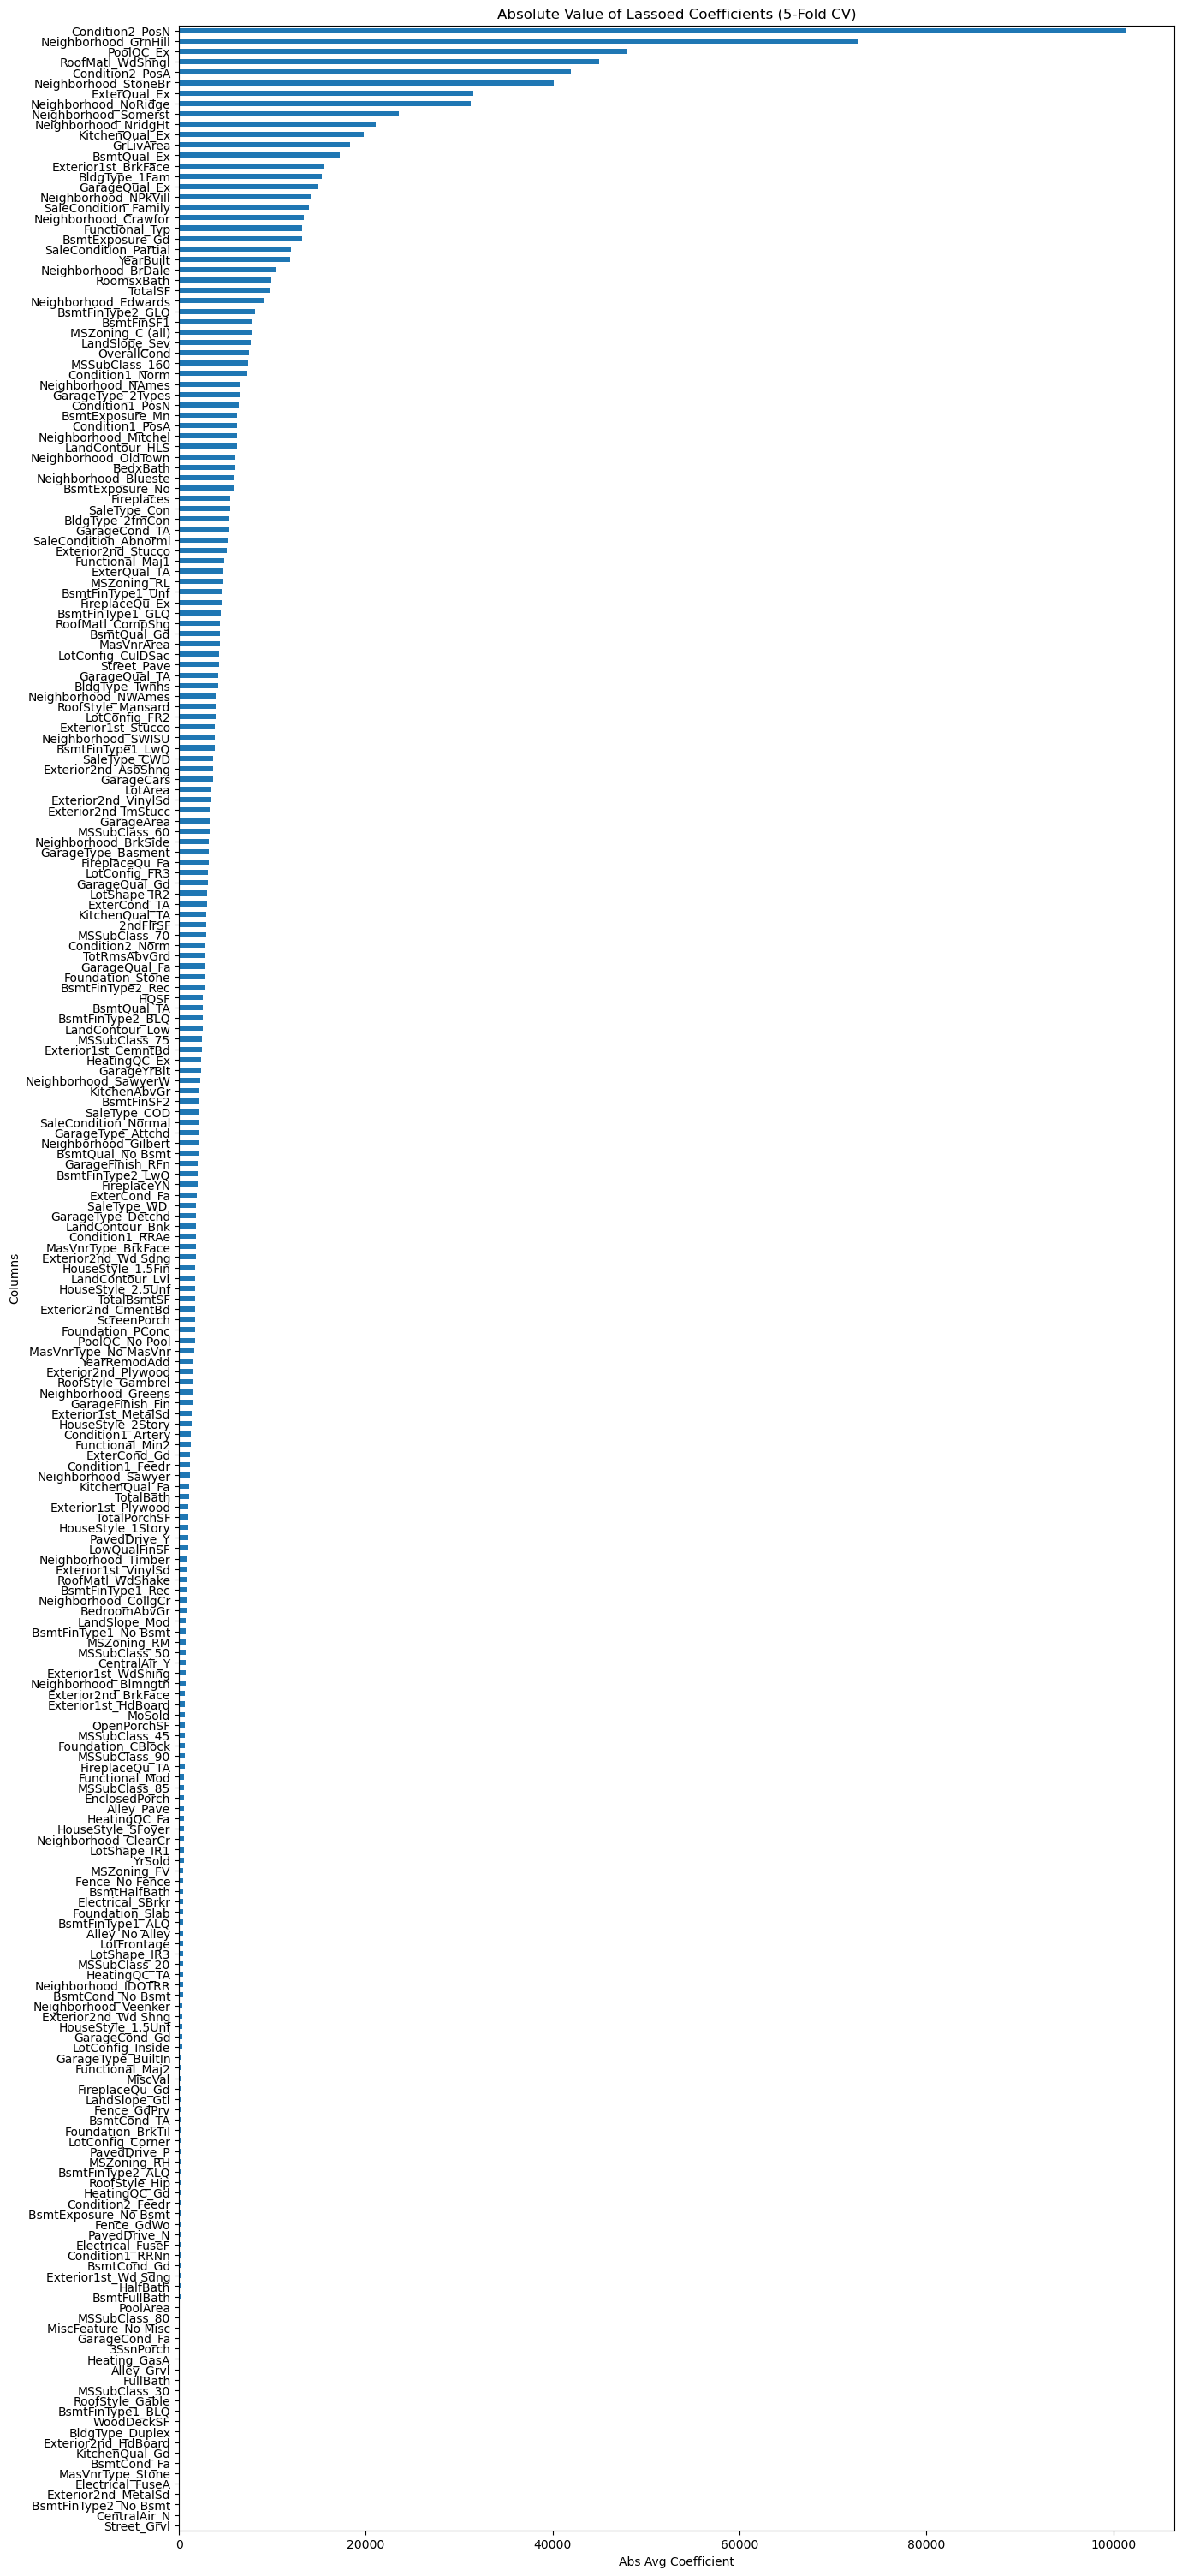

In [46]:
ax = lasso_coefs_sort.plot.barh(y= 'Abs Avg Coef', figsize = (15, 38), title = 'Absolute Value of Lassoed Coefficients (5-Fold CV)')
ax.invert_yaxis()
ax.set_xlabel('Abs Avg Coefficient')
ax.set_ylabel('Columns')
ax.get_legend().remove()

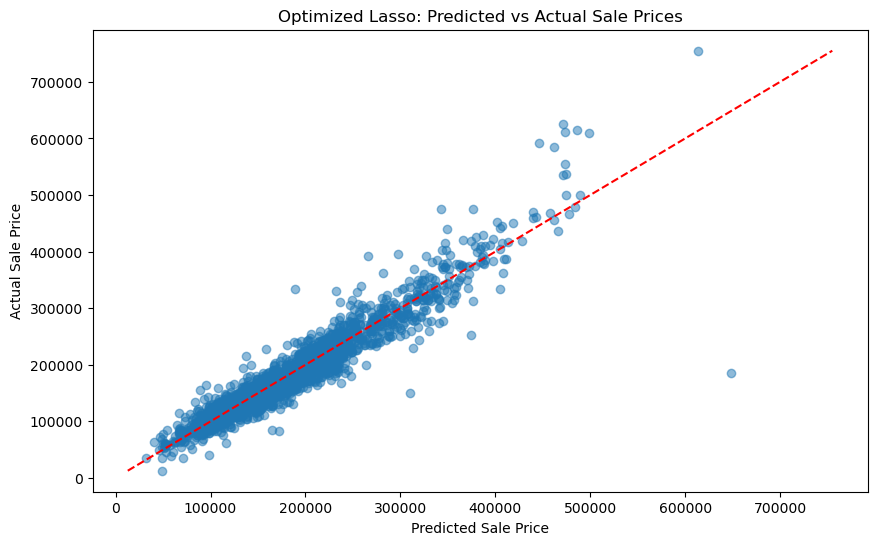

In [47]:
# Visualization of Predicted vs Actual Sale Prices
plt.figure(figsize=(10, 6))
plt.scatter(all_y_pred, all_y_actual, alpha=0.5)
plt.title('Optimized Lasso: Predicted vs Actual Sale Prices')
plt.xlabel('Predicted Sale Price')
plt.ylabel('Actual Sale Price')
plt.plot([min(all_y_actual), max(all_y_actual)], [min(all_y_actual), max(all_y_actual)], color='red', linestyle='--')
plt.show()

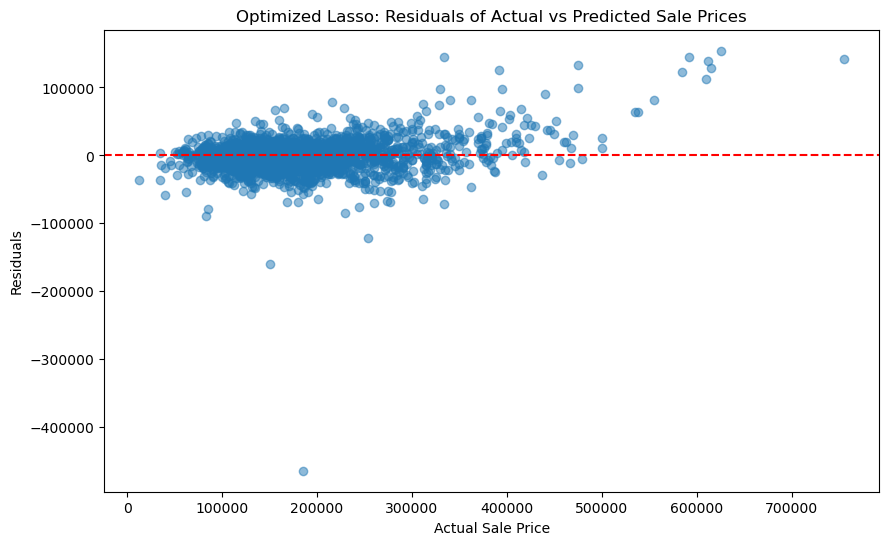

In [48]:
#Sale Price vs. Residuals
plt.figure(figsize=(10, 6))
plt.scatter(all_y_actual, residuals, alpha=0.5)
plt.title('Optimized Lasso: Residuals of Actual vs Predicted Sale Prices')
plt.xlabel('Actual Sale Price')
plt.ylabel('Residuals')
plt.axhline(y=0, color='red', linestyle='--')
plt.show()

### XIII. Ridge- Coefficients Closer Look- Specific Values/Feature Importances/Residuals
With cross-validation, you the exact coefficients for each fold/split of the dataset will be slightly different. Average the coefficients from each fold to get a general idea of feature magnitude/importance within the optimized ridge regression.

In [54]:
# Store scores and coefs
rmse_scores = []
r2_scores = []
coefs_per_fold = []

#Store info about residuals to plot
all_y_pred = []
all_y_actual = []
residuals = []

# Extracting all possible categories for OneHotEncoder
categorical_columns = X.select_dtypes(include=['object', 'category']).columns
all_categories = {col: X[col].unique() for col in categorical_columns}

preprocessor_2 = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), X.select_dtypes(include='number').columns),
        ('cat', OneHotEncoder(sparse_output=True, categories=[all_categories[col] for col in categorical_columns]), categorical_columns)
    ]
)

kf = KFold(n_splits=5, shuffle=False)

# Perform Cross-Validation
for fold, (train_index, test_index) in enumerate(kf.split(X)):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    # Fit the preprocessor on the training data and transform both train and test data
    X_train_scaled = preprocessor_2.fit_transform(X_train)
    X_test_scaled = preprocessor_2.transform(X_test)
    
    # Instantiate and fit Lasso
    ridge = Ridge(alpha=2.5, max_iter=30000, tol=0.001)
    ridge.fit(X_train_scaled, y_train)
    
    #Store 
    coefs_per_fold.append(ridge.coef_)
    
    y_pred = ridge.predict(X_test_scaled)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)
    rmse_scores.append(rmse)
    r2_scores.append(r2)
    
    #Residuals info to plot
    all_y_pred.extend(y_pred)
    all_y_actual.extend(y_test.values)
    residuals.extend(y_test.values - y_pred)
    
    #Print Results of Fold
    print(f"Fold {fold+1}: RMSE = {round(rmse, 4)}, R2 = {round(r2, 4)}")

mean_rmse = np.mean(rmse_scores)
mean_r2 = np.mean(r2_scores)
print(f"\nAlpha = 3")
print(f"Average RMSE: {round(mean_rmse, 4)}")
print(f"Average R2: {round(mean_r2, 4)}")
print("Completed: Calculating and storing coefficients for each column and each fold...")

Fold 1: RMSE = 31264.2079, R2 = 0.86
Fold 2: RMSE = 23109.0079, R2 = 0.9224
Fold 3: RMSE = 19702.8317, R2 = 0.9229
Fold 4: RMSE = 18827.157, R2 = 0.9194
Fold 5: RMSE = 19179.2904, R2 = 0.9215

Alpha = 3
Average RMSE: 22416.499
Average R2: 0.9093
Completed: Calculating and storing coefficients for each column and each fold...


In [55]:
#Create Dataframe of Ridge coefficients
feature_names = preprocessor_2.get_feature_names_out()  # Ensure the correct feature names
feature_names = [name.split('__')[1] if '__' in name else name for name in feature_names]
coef_df= pd.DataFrame(coefs_per_fold, columns = feature_names)
coef_df = coef_df.T
coef_df.columns = [f"Fold {i+1}" for i in range(coef_df.shape[1])]
coef_df['Std'] = coef_df.std(axis=1)
coef_df['Avg Coef'] = coef_df[['Fold 1', 'Fold 2', 'Fold 3', 'Fold 4', 'Fold 5']].mean(axis=1)
coef_df['Abs Avg Coef'] = coef_df['Avg Coef'].abs()

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)
print('Coefs for each feature across 5 folds')
coef_df

Coefs for each feature across 5 folds


,Fold 1,Fold 2,Fold 3,Fold 4,Fold 5,Std,Avg Coef,Abs Avg Coef
GrLivArea,11377.068752,9937.319665,11109.662937,10320.941081,1.028918e+04,607.656286,10606.835159,10606.835159
LotFrontage,-360.026864,96.274765,-944.164383,-504.734191,-4.715388e+02,371.921789,-436.837900,436.837900
LotArea,4310.467158,3295.960074,3714.513145,4463.361483,3.565812e+03,498.075610,3870.022854,3870.022854
OverallCond,6741.850720,7675.619120,7398.184697,7524.567875,7.626008e+03,379.308105,7393.246165,7393.246165
YearBuilt,7566.203157,6971.434641,7278.206569,7750.427602,6.954364e+03,354.103936,7304.127188,7304.127188
YearRemodAdd,5652.689452,4785.787031,5273.972972,5270.925363,5.156828e+03,310.215621,5228.040649,5228.040649
MasVnrArea,4883.237965,3533.719933,4078.646626,4686.677702,4.175944e+03,533.206930,4271.645282,4271.645282
BsmtFinSF1,6444.828370,6908.306967,6029.464942,6324.559923,5.275610e+03,604.291855,6196.554038,6196.554038
BsmtFinSF2,2201.799893,2182.782431,1382.134165,1707.367959,5.896382e+02,667.235112,1612.744524,1612.744524
BsmtUnfSF,-802.682498,-1829.282005,-1396.794657,-1622.951512,-2.975615e+03,797.451272,-1725.465164,1725.465164


In [56]:
ridge_coefs_sort = coef_df.sort_values(by='Abs Avg Coef', ascending=False)

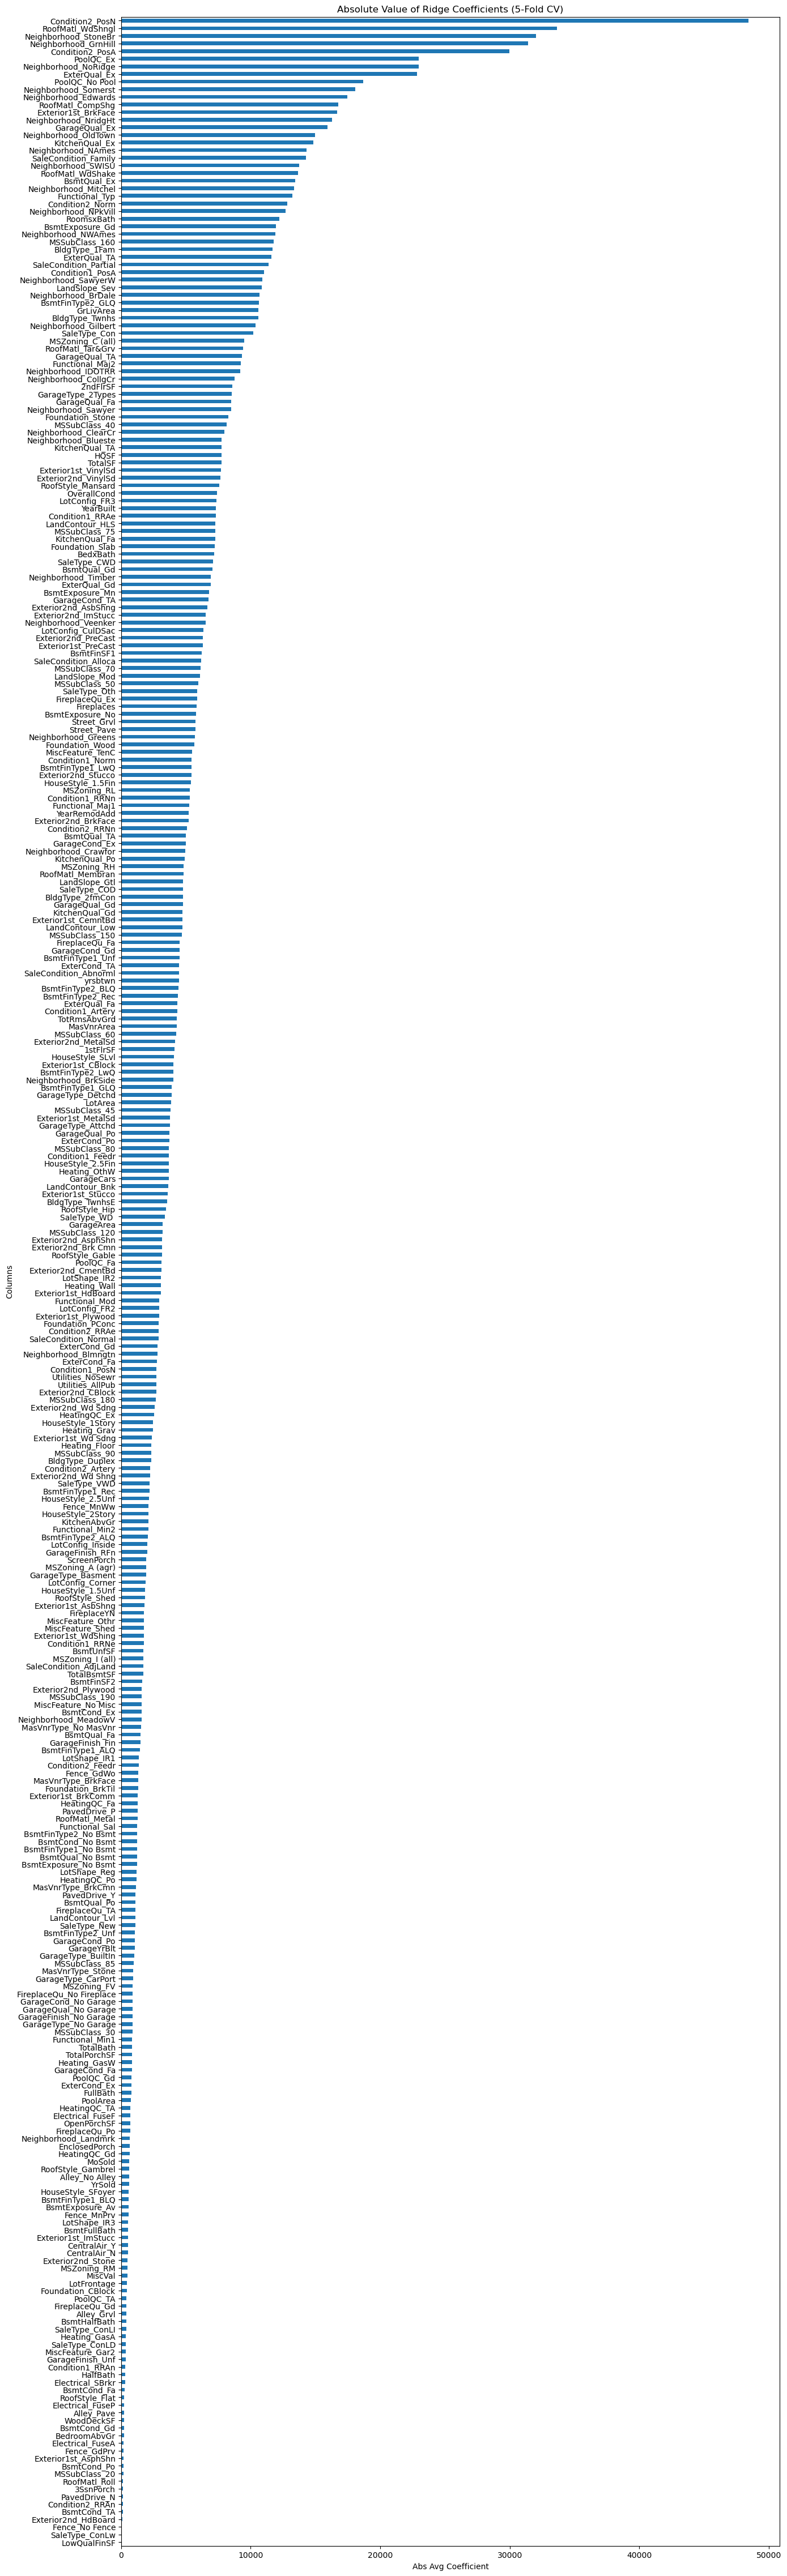

In [59]:
ax = ridge_coefs_sort.plot.barh(y= 'Abs Avg Coef', figsize = (15, 58), title = 'Absolute Value of Ridge Coefficients (5-Fold CV)')
ax.invert_yaxis()
ax.set_xlabel('Abs Avg Coefficient')
ax.set_ylabel('Columns')
ax.get_legend().remove()

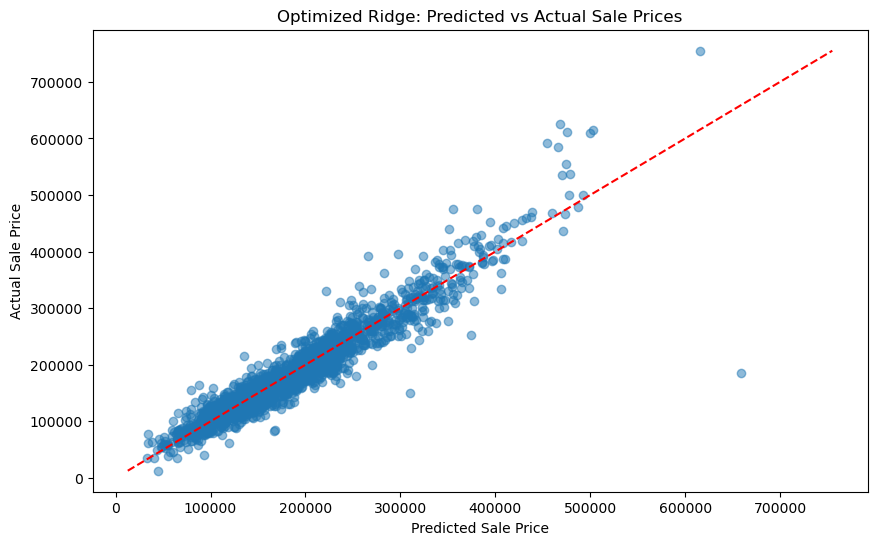

In [60]:
# Visualization of Predicted vs Actual Sale Prices
plt.figure(figsize=(10, 6))
plt.scatter(all_y_pred, all_y_actual, alpha=0.5)
plt.title('Optimized Ridge: Predicted vs Actual Sale Prices')
plt.xlabel('Predicted Sale Price')
plt.ylabel('Actual Sale Price')
plt.plot([min(all_y_actual), max(all_y_actual)], [min(all_y_actual), max(all_y_actual)], color='red', linestyle='--')
plt.show()

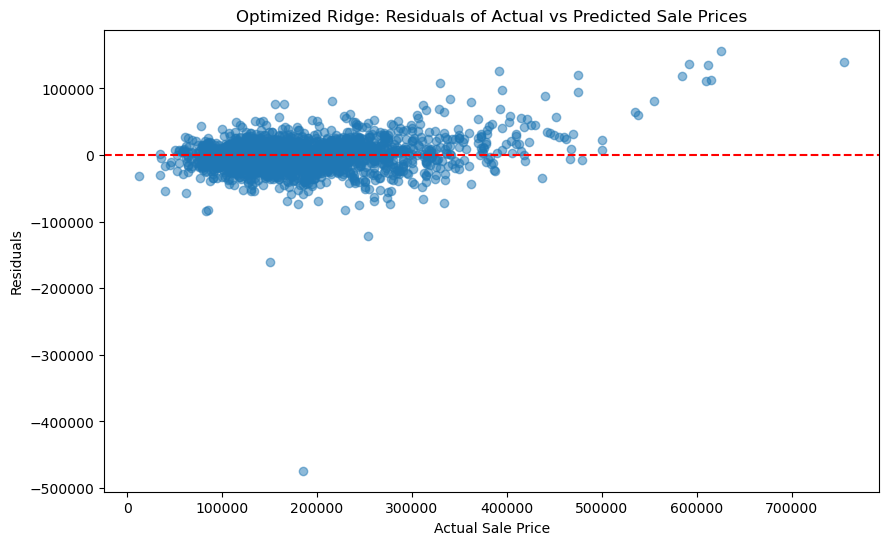

In [61]:
#Sale Price vs. Residuals
plt.figure(figsize=(10, 6))
plt.scatter(all_y_actual, residuals, alpha=0.5)
plt.title('Optimized Ridge: Residuals of Actual vs Predicted Sale Prices')
plt.xlabel('Actual Sale Price')
plt.ylabel('Residuals')
plt.axhline(y=0, color='red', linestyle='--')
plt.show()

In [64]:
output_file = 'master_scores_PLR.csv'

plr_df.to_csv(output_file, index=False, mode='w')

print(f"DataFrame exported to '{output_file}' in the same working directory.")

DataFrame exported to 'master_scores_PLR.csv' in the same working directory.
